<a href="https://colab.research.google.com/github/rajanvikash/Research-Paragraphs-Extractor/blob/main/Paragraphs_extractor_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow_hub as hub
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix , classification_report

In [2]:
import sklearn.externals  # joblib is file creator for storing our trained model
import joblib

In [ ]:
!pip install tensorflow_text==2.8.2
import tensorflow_text as text
print(text.__version__)

In [ ]:
encoder_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
preprocess_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [ ]:
preprocess_model = hub.KerasLayer(preprocess_url)
bert_model = hub.KerasLayer(encoder_url)

Creating neural network layeers

In [ ]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = preprocess_model(text_input)
outputs = bert_model(preprocessed_text)

In [ ]:
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

Reading files

In [5]:
df = pd.read_csv('/content/train_para.csv')
df.head(10)

,Paragraph,Classifier
0,The SLs were grown by pulsed laser deposition ...,1
1,"Here, we report on the formation of large area...",1
2,Thin films ofw-BN are grown by pulsed laser de...,1
3,Interconnected ZnO core/shell nanorods were gr...,1
4,"Before deposition, the substrates were heated ...",1
5,The lower laser pulse energy of 110 mJ and flu...,1
6,The experiments of thin coatings deposition we...,1
7,"For the preparation of thin films synthetic, p...",1
8,Zr50Cu50(% at.) thin films have been deposited...,1
9,Sb2Te3thin films were grown on 20 nm thick sil...,1


In [6]:
df.Classifier.value_counts()


0    4653
1     577
Name: Classifier, dtype: int64

In [7]:
count_class_0 , count_class_1 = df.Classifier.value_counts()
print(count_class_0 , count_class_1)

4653 577


In [8]:
df_class_0 = df[df['Classifier']== 0]
df_class_0.shape

(4653, 2)

In [9]:
df_class_1 = df[df['Classifier']== 1]
df_class_1.shape

(577, 2)

**Under sample model**      ☹*starts here.........................................*

In [ ]:
df_class_0_under = df_class_0.sample(count_class_1 , replace = True)
df_class_0_under.shape

(179, 2)

In [ ]:
df_undersample = pd.concat([df_class_1 , df_class_0_under], axis = 0)
df_undersample.shape

(358, 2)

In [ ]:
x_under =df_undersample.Paragraph
y_under = df_undersample.Classifier.astype(np.float32) 

In [ ]:
len(x_under ) ,len(y_under )

(358, 358)

In [ ]:
from sklearn.model_selection import train_test_split
x_under_train , x_under_test , y_under_train , y_under_test = train_test_split(x_under , y_under , test_size = 0.2, stratify = y_under )
len(x_under_test)/len(x_under_train)

0.2517482517482518

In [ ]:
model_under = tf.keras.Model(inputs=[text_input], outputs = [l])
model_under.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

In [ ]:
model_under.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
y_under_train.value_counts()

1.0    143
0.0    143
Name: Classifier, dtype: int64

In [ ]:
model_under.fit(x_under_train, y_under_train, epochs=100)

Epoch 1/100
9/9 [==============================] - 3s 333ms/step - loss: 0.4796 - accuracy: 0.7902
Epoch 2/100
9/9 [==============================] - 3s 338ms/step - loss: 0.4633 - accuracy: 0.8112
Epoch 3/100
9/9 [==============================] - 3s 339ms/step - loss: 0.4727 - accuracy: 0.7972
Epoch 4/100
9/9 [==============================] - 3s 338ms/step - loss: 0.4678 - accuracy: 0.8217
Epoch 5/100
9/9 [==============================] - 3s 342ms/step - loss: 0.4584 - accuracy: 0.8042
Epoch 6/100
9/9 [==============================] - 3s 343ms/step - loss: 0.4695 - accuracy: 0.8252
Epoch 7/100
9/9 [==============================] - 3s 383ms/step - loss: 0.4600 - accuracy: 0.7902
Epoch 8/100
9/9 [==============================] - 3s 380ms/step - loss: 0.4576 - accuracy: 0.8147
Epoch 9/100
9/9 [==============================] - 3s 349ms/step - loss: 0.4550 - accuracy: 0.8357
Epoch 10/100
9/9 [==============================] - 3s 347ms/step - loss: 0.4621 - accuracy: 0.8252
Epoch 11/

In [ ]:
y_under_predict = model_under.predict(x_under_test)

In [ ]:
test_under = [[x] for x in y_under_test]

In [ ]:
y_under_preds = np.round(y_under_predict)
print(classification_report(test_under , y_under_preds))
print(confusion_matrix(test_under , y_under_preds))

              precision    recall  f1-score   support

         0.0       0.81      0.69      0.75        36
         1.0       0.73      0.83      0.78        36

    accuracy                           0.76        72
   macro avg       0.77      0.76      0.76        72
weighted avg       0.77      0.76      0.76        72

[[25 11]
 [ 6 30]]


In [ ]:
joblib.dump(model_under,'/content/drive/MyDrive/Ugp_1/under_sample_model' )

INFO:tensorflow:Assets written to: ram://6eadd62e-34f6-4ed3-bdad-043a8603c07f/assets


INFO:tensorflow:Assets written to: ram://6eadd62e-34f6-4ed3-bdad-043a8603c07f/assets


['/content/drive/MyDrive/Ugp_1/under_sample_model']

Oversampling by duplication starts here ...............................................

---



In [10]:
df_class_1_over = df_class_1.sample(count_class_0 , replace = True)
df_class_1_over.shape

(4653, 2)

In [11]:
count_class_1

577

In [12]:
df_dup = pd.concat([df_class_0 , df_class_1_over] , axis = 0 , ignore_index = True)
df_dup.shape

(9306, 2)

In [13]:
x =df_dup.Paragraph
y = df_dup.Classifier.astype(np.float32) 

In [14]:
from sklearn.model_selection import train_test_split
x_train , x_test , y_train , y_test = train_test_split(x , y , test_size = 0.4, stratify = df_dup.Classifier )
len(x_test)/len(x_train)

0.6668457818377217

In [15]:
y_train.value_counts()

0.0    2792
1.0    2791
Name: Classifier, dtype: int64

In [ ]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = preprocess_model(text_input)
outputs = bert_model(preprocessed_text)

In [ ]:
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

In [ ]:
model = tf.keras.Model(inputs=[text_input], outputs = [l])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(x_train, y_train, epochs=60)



```
for Epoch = 20 Acuuracy = 0.8694




```



In [ ]:
y_predict = model.predict(x_test)


In [17]:
y_test.value_counts()

1.0    1862
0.0    1861
Name: Classifier, dtype: int64

In [18]:
test = [[x] for x in y_test]


In [ ]:
import numpy as np
y_preds = np.round(y_predict)
print(classification_report(test , y_preds))
print(confusion_matrix(test , y_preds))

              precision    recall  f1-score   support

         0.0       0.95      0.92      0.93       931
         1.0       0.92      0.95      0.94       931

    accuracy                           0.93      1862
   macro avg       0.93      0.93      0.93      1862
weighted avg       0.93      0.93      0.93      1862

[[854  77]
 [ 45 886]]


In [ ]:
joblib.dump(model,'/content/drive/MyDrive/Ugp_1/over_sample_model_4' )

In [4]:
model = joblib.load('/content/drive/MyDrive/Ugp_1/over_sample_model_4')

In [16]:
yjob_predict = model.predict(x_test)

In [19]:
import numpy as np
y_preds = np.round(yjob_predict)
print(classification_report(test , y_preds))
print(confusion_matrix(test , y_preds))

              precision    recall  f1-score   support

         0.0       0.94      0.92      0.93      1861
         1.0       0.92      0.94      0.93      1862

    accuracy                           0.93      3723
   macro avg       0.93      0.93      0.93      3723
weighted avg       0.93      0.93      0.93      3723

[[1708  153]
 [ 114 1748]]


In [20]:
cm = confusion_matrix(test , y_preds)

Text(69.0, 0.5, 'Actual')

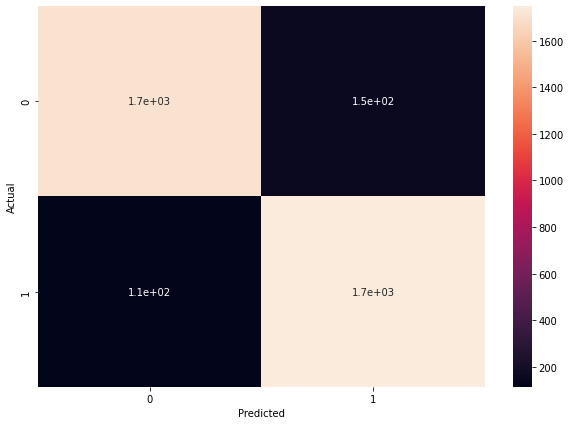

In [21]:
import seaborn as sn 
from matplotlib import pyplot as plt
plt.figure(figsize = (10,7))
sn.heatmap(cm , annot = True)
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [22]:
df5 = pd.read_csv('/content/combo_only_para.csv')
df5.head()

,Paragraph
0,BiFeO3 (BFO) is under intense investigation be...
1,The SLs were grown by pulsed laser deposition ...
2,Table 1below presents the characteristics of t...
3,Fig. 1presents the X-ray diffraction pattern i...
4,In order to get access to the out of plane lat...


In [23]:
para = [item for item in df5['Paragraph']]
len(para) # it is the input of paragraphs for prediction

163228

In [24]:
type(para[100])

str

In [25]:
model.predict([para[0]])

array([[0.05052511]], dtype=float32)

In [ ]:
i =0
j = 163228
list = []
for idx in range(i, j):
  try:
    d= model.predict([para[idx]])
    if d[0][0]>0.7:
      list.append([idx,para[idx]])
      print(idx , "  ", d[0][0])
      
    
  except:
    continue
  


In [27]:
len(list) # it is the final extraction out of 163k paragraphs

8811

In [ ]:
i =0
j = 2000
list2 = []
for idx in range(i, j):
  try:
    d= model.predict([para[idx]])
    if d[0][0]>0.8:           # only choosing those having probality > 0.8
      list2.append([idx,para[idx]])
      print(idx , "  ", d[0][0])
      
    
  except:
    continue

415    0.8019271
486    0.80982906
779    0.8041742
780    0.83008397
782    0.83156174
1613    0.8048578
1862    0.81102675
1865    0.83125734


In [28]:
df_7 = pd.DataFrame(list)
df_7.rename(columns = {0:'index', 1:'Paragraph'}, inplace = True)
df_7.head()


,index,Paragraph
0,1,The SLs were grown by pulsed laser deposition ...
1,22,Thin films of w-BN are grown by pulsed laser d...
2,42,Interconnected ZnO core/shell nanorods were gr...
3,43,"Before deposition, the substrates were heated ..."
4,58,SrHA nanocrystals were synthesized in N2 atmos...


In [29]:
df_7.to_csv('final_extraction.csv', index = False)# storing extraction to csv file 